# `Fully Convolutional Neural Network Parameterizations`

## 1 - Introduction & Setup

In this notebook, we'll demonstrate loading and evaluating one of our fully convolutional neural network (FCNN) parameterizations.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyqg
import json
import fsspec
from pyqg_parameterization_benchmarks.neural_networks import FCNNParameterization
from pyqg_parameterization_benchmarks.utils import energy_budget_figure

%matplotlib inline
plt.rcParams.update({'font.size': 13})

- Conv2D          : simple 2D convolution                                       (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- BatchNorm2d     : applying a normalization of the mini-batch after each layer (https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
- CircularPadding : see paper Benchmarking of machine learning ocean subgrid parameterizations in an idealized model

In [2]:
param = FCNNParameterization('../models/fcnn_q_to_Sqtot1')

# Print out a summary of its architecture -- note the circular padding,
# which was particularly important for performance.
param.models[0]

['../models/fcnn_q_to_Sqtot1/models/0', '../models/fcnn_q_to_Sqtot1/models/1']
yessss
yessss


FullyCNN(
  (0): Conv2d(2, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=circular)
  (1): ReLU()
  (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=circular)
  (4): ReLU()
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (7): ReLU()
  (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (10): ReLU()
  (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (13): ReLU()
  (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [3]:
# Datasets are hosted on globus as zarr files
def get_dataset(path, base_url="https://g-402b74.00888.8540.data.globus.org"):
    mapper = fsspec.get_mapper(f"{base_url}/{path}.zarr")
    return xr.open_zarr(mapper, consolidated=True)

In [4]:
# This dataset has the same distribution as the FCNN's training data, but is not something the FCNN has seen
# (we regenerated the dataset after pyqg changes which standardized/saved more diagnostics).
eddy_forcing1 = get_dataset('eddy/forcing1').isel(run=0).load()
eddy_forcing1['q_forcing_total'] = eddy_forcing1.dqdt_bar - eddy_forcing1.dqbar_dt

## Test it offline

In [5]:
print(eddy_forcing1)

<xarray.Dataset>
Dimensions:            (l: 64, k: 33, lev: 2, time: 87, y: 64, x: 64, lev_mid: 1)
Coordinates:
  * k                  (k) float32 0.0 6.283e-06 ... 0.0001948 0.0002011
  * l                  (l) float32 0.0 6.283e-06 ... -1.257e-05 -6.283e-06
  * lev                (lev) int32 1 2
  * lev_mid            (lev_mid) float32 1.5
  * time               (time) float32 0.0 3.6e+06 7.2e+06 ... 3.06e+08 3.096e+08
  * x                  (x) float32 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y                  (y) float32 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
Data variables: (12/37)
    APEflux            (l, k) float32 -0.0 8.36e-15 ... 3.116e-27 -4.992e-33
    APEgen             float32 7.488e-11
    APEgenspec         (l, k) float32 0.0 -2.465e-15 ... 1.682e-38 -0.0
    Dissspec           (l, k) float32 -0.0 -0.0 -0.0 ... -2.671e-26 -8.976e-32
    EKE                (lev) float32 0.002634 8.083e-05
    EKEdiss            float32 7.484e-11
    ...                 ...

In [6]:
preds = param.test_offline(eddy_forcing1)

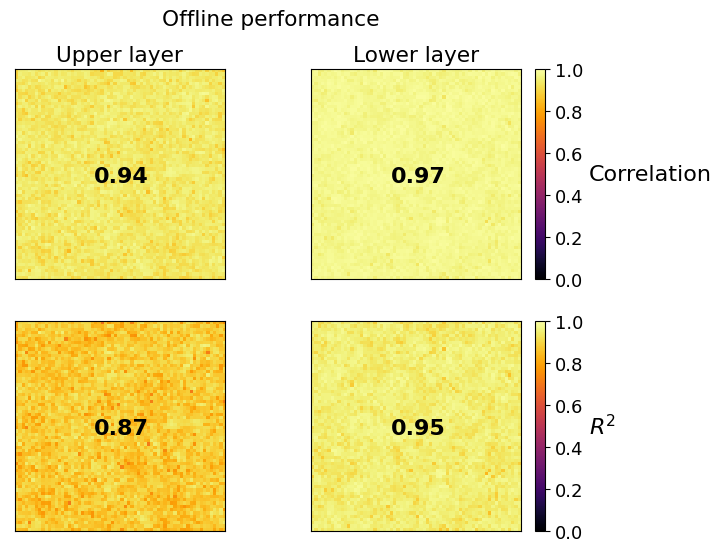

In [11]:
def imshow(arr):
    plt.imshow(arr, vmin=0, vmax=1, cmap='inferno')
    mean = arr.mean().data
    plt.text(32, 32, f"{mean:.2f}", color=('white' if mean<0.75 else 'black'),
             fontweight='bold', ha='center', va='center', fontsize=16)
    plt.xticks([]); plt.yticks([])
    
def colorbar(label):
    plt.colorbar().set_label(label, fontsize=16,rotation=0,ha='left',va='center')
    
plt.figure(figsize=(7.6,6)).suptitle("Offline performance")

# Looping over all levels of the simulation
for z in [0,1]:
    plt.subplot(2,2,z+1,title=f"{['Upper','Lower'][z]} layer")
    imshow(preds.q_forcing_total_spatial_correlation.isel(lev=z))
    if z: colorbar("Correlation")
    
for z in [0,1]:
    plt.subplot(2,2,z+3)
    imshow(preds.q_forcing_total_spatial_skill.isel(lev=z))
    if z: colorbar("$R^2$")

Compared to [our symbolic regression results](./hybrid_symbolic.ipynb), the FCNN's offline performance is clearly stronger.

## Run it online (if you have a GPU)

This may take a while if you don't:

In [ ]:
%%time
hires = get_dataset('eddy/high_res').isel(run=0)
lores = get_dataset('eddy/low_res').isel(run=0)
param_run = param.run_online(**json.loads(eddy_forcing1.pyqg_params))

Even with a GPU, it takes a similar amount of time to run an FCNN-parameterized as it does to run a high-res simulation! But let's take a look:

In [12]:
eddy_sims = [(hires, 'High-res'),(lores, 'Low-res'),(param_run,'Low-res+FCNN')]
fig = energy_budget_figure(eddy_sims)
fig.suptitle("Energy budget comparison, fully convolutional neural network")
plt.tight_layout()
plt.show()

NameError: name 'hires' is not defined

Overall, this seems to be an improvement. In our paper, we quantify these differences using a ratio of FCNN-highres and lowres-highres differences.

Let's look at some raw data snapshots just to confirm everything looks ok:

In [ ]:
plt.figure(figsize=(13,4)).suptitle("Upper PV snapshots")
for i, (m, label) in enumerate(eddy_sims):
    plt.subplot(1,3,i+1, title=label)
    plt.imshow(m.q.isel(lev=0,time=-1), cmap='bwr', vmin=-3e-5, vmax=3e-5)
plt.colorbar(label="Upper PV [$s^{-1}$]")
plt.tight_layout()

The FCNN-parameterized model seems to have larger overall values for the upper PV. We can also confirm this by looking at marginal distributions:

In [ ]:
from scipy.stats import gaussian_kde
plt.title("Differences in distributions of quasi-steady $q_1$")
for i, (m, label) in enumerate(eddy_sims):
    data = m.q.isel(lev=0,time=slice(-20,None)).data.ravel()
    dist = gaussian_kde(data)
    x = np.linspace(*np.percentile(data, [1,99]), 1000)
    plt.plot(x, dist(x), label=label, lw=3, ls=('--' if 'FCNN' in label else '-'))
plt.legend()
plt.xlabel("Upper PV [$s^{-1}$]")
plt.ylabel("Probability density")
plt.tight_layout()

The FCNN's distribution is much, much closer. In the paper, we quantify this with Wasserstein distance over a much larger set of variables.

## Testing generalization

Now, although our FCNN performs well in a context that matches its training data, neural networks often have trouble generalizing to new domains. Let's try it with a second "jet" configuration:

In [ ]:
# This dataset has the same distribution as the FCNN's training data, but is not something the FCNN has seen
# (we regenerated the dataset after pyqg changes which standardized/saved more diagnostics).
jet_forcing1 = get_dataset('jet/forcing1').isel(run=0).load()
jet_forcing1['q_forcing_total'] = jet_forcing1.dqdt_bar - jet_forcing1.dqbar_dt

In [ ]:
preds2 = param.test_offline(jet_forcing1)

In [ ]:
plt.figure(figsize=(7.6,6)).suptitle("Offline performance, jet config")

for z in [0,1]:
    plt.subplot(2,2,z+1,title=f"{['Upper','Lower'][z]} layer")
    imshow(preds2.q_forcing_total_spatial_correlation.isel(lev=z))
    if z: colorbar("Correlation")
    
for z in [0,1]:
    plt.subplot(2,2,z+3)
    imshow(preds2.q_forcing_total_spatial_skill.isel(lev=z))
    if z: colorbar("$R^2$")

Although the FCNN's correlation is still reasonably high, its $R^2$ drops significantly, going negative in the lower layer. Note that across different random restarts, FCNN behavior varies here (some models have negative $R^2$s in both layers, even going down to -5 or lower).

Let's see what happens online:

In [ ]:
hires2 = get_dataset('jet/high_res').isel(run=0)
lores2 = get_dataset('jet/low_res').isel(run=0)
param_run2 = param.run_online(**json.loads(jet_forcing1.pyqg_params))

In [ ]:
jet_sims = [(hires2, 'High-res'),(lores2, 'Low-res'),(param_run2,'Low-res+FCNN')]
fig = energy_budget_figure(jet_sims, skip=3) # skip first 3 wavenumbers so the plot limits are more readable
fig.suptitle("Energy budget comparison, fully convolutional neural network on jet config")
plt.tight_layout()
plt.show()

There appears to be much too much energy in the FCNN-parameterized simulation. Let's take a look at snapshots again to see what's happening:

In [ ]:
plt.figure(figsize=(13,4)).suptitle("Upper PV snapshots, jet config")
for i, (m, label) in enumerate(jet_sims):
    plt.subplot(1,3,i+1, title=label)
    plt.imshow(m.q.isel(lev=0,time=-1), cmap='bwr', vmin=-3e-5, vmax=3e-5)
plt.colorbar(label="Upper PV [$s^{-1}$]")
plt.tight_layout()

Instead of a coherent and vertically symmetrical 4-jet pattern, we see significant global structure that almost resembles a single jet. This problem could likely be mitigated by training on a more diverse set of data.